# Import package and module

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

In [2]:
tf.config.list_physical_devices("GPU")
!nvidia-smi

Thu May 12 12:06:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:29:00.0  On |                  N/A |
| 49%   49C    P8    20W / 125W |    961MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load path

In [3]:
train_dir = './cigarette-smoker-detection-kaggle/train'
test_dir = './cigarette-smoker-detection-kaggle/test'

# Preprocessing

### Preprocessing

In [4]:
img_size = 224
batch_size = 32
seed = 72
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    label_mode="binary",
    image_size=(img_size,img_size),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 3185 files belonging to 2 classes.
Using 2548 files for training.
Found 3185 files belonging to 2 classes.
Using 637 files for validation.
Found 90 files belonging to 2 classes.


In [11]:
train_ds.class_names

['not_smoking', 'smoking']

## Rescale

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
print("\nRescale Successful")


Rescale Successful


# Train

In [10]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(img_size, img_size, 3),
    weights="imagenet",
    include_preprocessing=False,
    include_top=False,
    pooling="avg"
)

base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(units=1, activation = "sigmoid")
])

In [12]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

Model Summary

In [13]:
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Start train

In [14]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

print("\n==========================")
print("======= Train done =======")
print("==========================")

Epoch 1/300
80/80 [==============================] - 47s 499ms/step - loss: 0.5249 - accuracy: 0.7410 - precision_1: 0.7631 - recall_1: 0.8339 - val_loss: 0.4225 - val_accuracy: 0.8132 - val_precision_1: 0.8444 - val_recall_1: 0.8593
Epoch 2/300
80/80 [==============================] - 17s 198ms/step - loss: 0.3981 - accuracy: 0.8234 - precision_1: 0.8265 - recall_1: 0.8989 - val_loss: 0.3784 - val_accuracy: 0.8336 - val_precision_1: 0.8460 - val_recall_1: 0.8970
Epoch 3/300
80/80 [==============================] - 17s 198ms/step - loss: 0.3560 - accuracy: 0.8540 - precision_1: 0.8530 - recall_1: 0.9189 - val_loss: 0.3686 - val_accuracy: 0.8430 - val_precision_1: 0.8763 - val_recall_1: 0.8719
Epoch 4/300
80/80 [==============================] - 17s 198ms/step - loss: 0.3293 - accuracy: 0.8673 - precision_1: 0.8675 - recall_1: 0.9234 - val_loss: 0.3525 - val_accuracy: 0.8509 - val_precision_1: 0.8741 - val_recall_1: 0.8894
Epoch 5/300
80/80 [==============================] - 17s 198ms/s

Result #1 train

In [15]:
acc = history_1.history['accuracy']
prec = history_1.history['precision_1']
recall = history_1.history['recall_1']
loss = history_1.history['loss']

val_acc = history_1.history['val_accuracy']
val_prec = history_1.history['val_precision_1']
val_recall = history_1.history['val_recall_1']
val_loss = history_1.history['val_loss']

In [16]:
save_path = './Developed-model/exp4'
model.save(save_path)
print("\nModel has been saved")

INFO:tensorflow:Assets written to: ./Developed-model/exp4\assets


INFO:tensorflow:Assets written to: ./Developed-model/exp4\assets



Model has been saved


In [17]:
print("\nEvaluating the model with test set")
model.evaluate(test_ds)


Evaluating the model with test set
3/3 [==============================] - 1s 310ms/step - loss: 1.5341 - accuracy: 0.7444 - precision_1: 0.6618 - recall_1: 1.0000


[1.534061312675476, 0.7444444298744202, 0.6617646813392639, 1.0]

# Export Fine tune 1 metrics result to csv

In [18]:
data = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
export_data = zip_longest(*data, fillvalue = '')

with open('exp4.csv', 'w', encoding="ISO-8859-1", newline='') as file:
      write = csv.writer(file)
      write.writerow(("acc", "prec", "recall", "loss", "val_acc", "val_prec", "val_recall", "val_loss"))
      write.writerows(export_data)

print("\nTrain result has been saved")


Train result has been saved


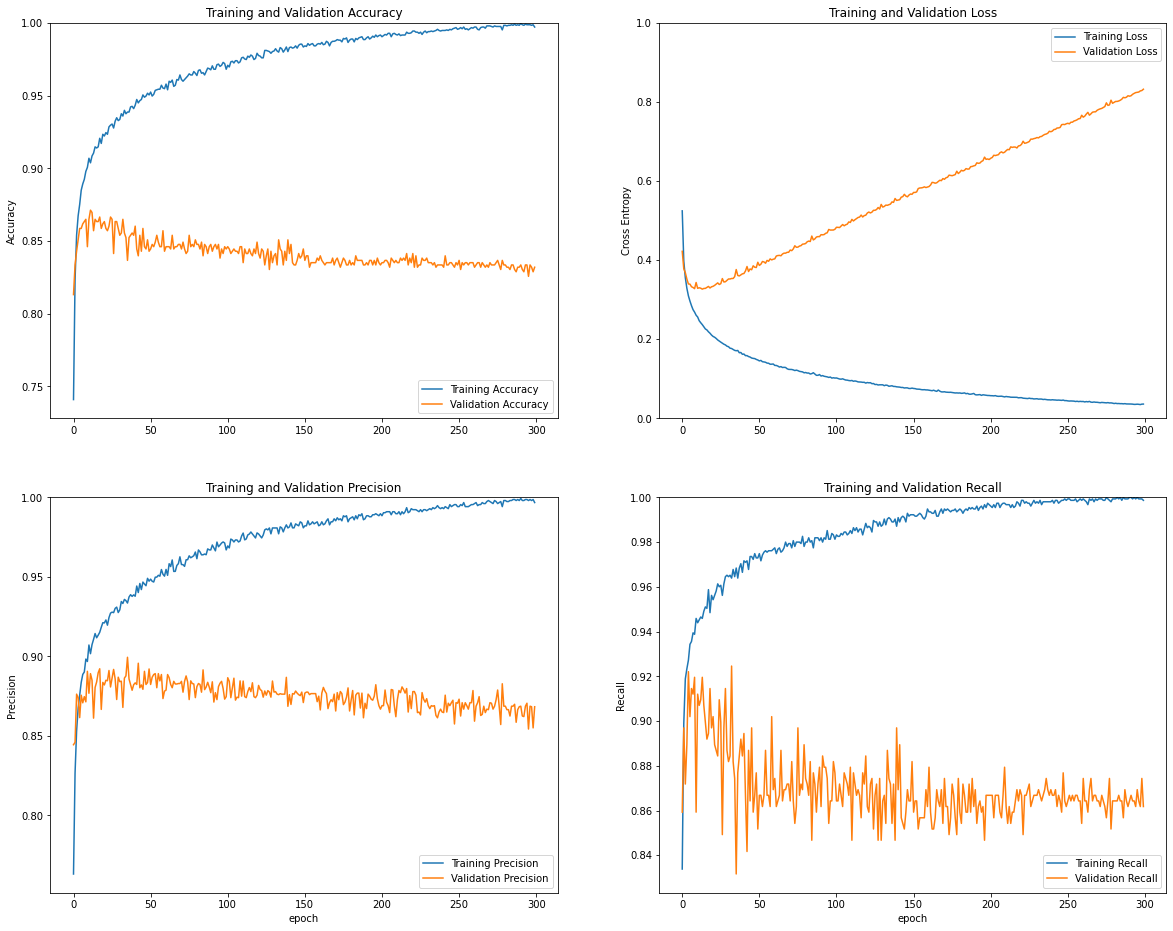

In [19]:
plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()